Name: Bor-Sheng Huang  
Github Username: borsheng  
USC ID: 9589131162  

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from itertools import chain
from scipy.stats import bootstrap

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix, roc_curve, auc, zero_one_loss, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, ShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.utils import resample
from itertools import cycle
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 1. HW3: Time Series Classification Part 1: Feature Creation/Extraction 

In [2]:
column_names = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
folder_paths = ['../data/AReM/bending1', '../data/AReM/bending2', '../data/AReM/cycling', '../data/AReM/lying', '../data/AReM/sitting', '../data/AReM/standing', '../data/AReM/walking']

# 0:bending, 1:cycling, 2:lying, 3:sitting, 4:standing, 5:walking
label_names = [0, 0, 1, 2, 3, 4, 5]  

all_rows = []

for i, path in enumerate(folder_paths):
    csv_files = sorted(glob.glob(os.path.join(path, "*.csv")))
    
    for f in csv_files:
        df = pd.read_csv(f, skiprows=5, names=column_names)
        
        df = df.drop(columns="time").describe().drop('count')
        row_data = list(chain.from_iterable(df.transpose().values.tolist()))
        
        row_data.append(label_names[i])
        all_rows.append(row_data)

# dynamically create column names
columns = [f"{stat}{j}" for j in range(1, 7) for stat in ['mean', 'std', 'min', '25%', 'median', '75%', 'max']]
columns.append('label')

df = pd.DataFrame(all_rows, columns=columns)
df.index += 1

features = df.drop(columns='label')
confidence_intervals = {}
std_deviation = []

for column in features.columns:
    # use bootstrap to calculate
    boot_result = bootstrap((features[column],), np.std, confidence_level=0.9, n_resamples=1000, method='basic')
    
    # extract the lower and upper bounds of the confidence interval
    lower, upper = boot_result.confidence_interval.low, boot_result.confidence_interval.high
    # save standard deviation in array
    std_deviation.append(np.std(features[column]))
    
    confidence_intervals[column] = {
        'std': np.std(features[column]),
        'lower': lower,
        'upper': upper
    }

# calculate standard deviation for each feature's standard deviation
feature_std_matrix = np.reshape(std_deviation, (6, 7)).T
feature_std_devs = np.std(feature_std_matrix, axis=1)

# create a dataframe to display the results
feature_names = ['mean', 'std', 'min', '25%', 'median', '75%', 'max']
feature_std_df = pd.DataFrame({name: [std] for name, std in zip(feature_names, feature_std_devs)})

display(feature_std_df)
print('The top three standard deviation is min, 25%, median')

,mean,std,min,25%,median,75%,max
0,1.916563,0.428269,3.620955,2.392576,2.005978,1.658896,1.31378


The top three standard deviation is min, 25%, median


In [3]:
# split data into training and testing data
testing_set_id = [0, 1, 7, 8, 12, 13, 14, 27, 28, 29, 42, 43, 44, 57, 58, 59, 72, 73, 74]

train_data = [row for idx, row in enumerate(df.values.tolist()) if idx not in testing_set_id]
test_data = [row for idx, row in enumerate(df.values.tolist()) if idx in testing_set_id]

train_data = np.array(train_data)
test_data = np.array(test_data)

train_feature = train_data[:, :-1]
train_label = train_data[:, -1]

test_feature = test_data[:, :-1]
test_label = test_data[:, -1]

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

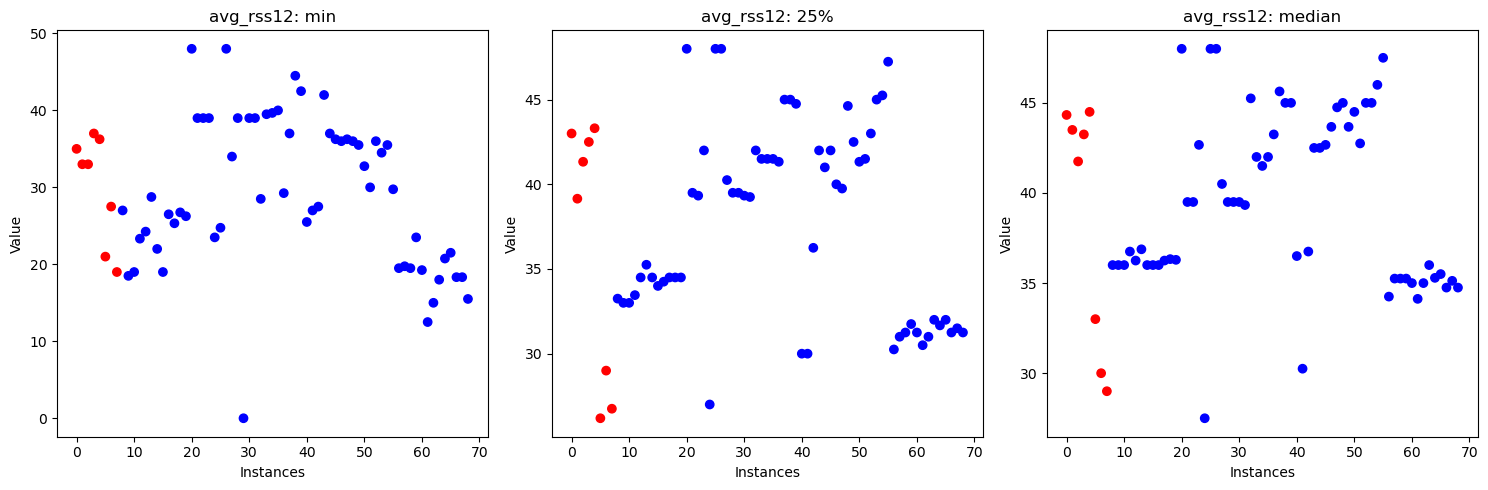

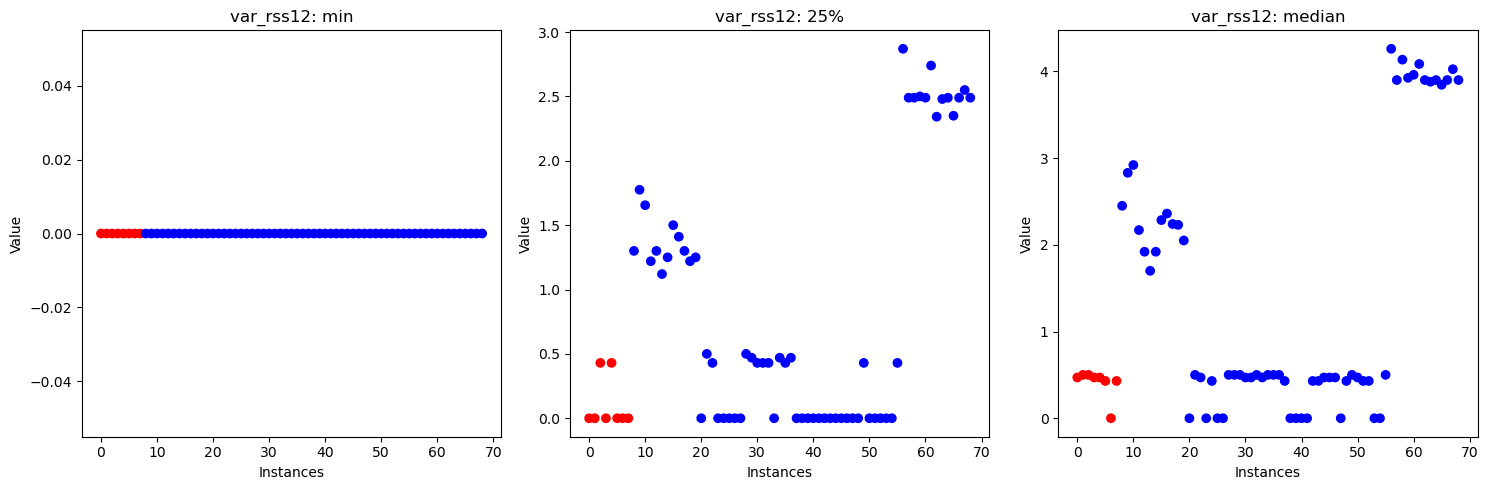

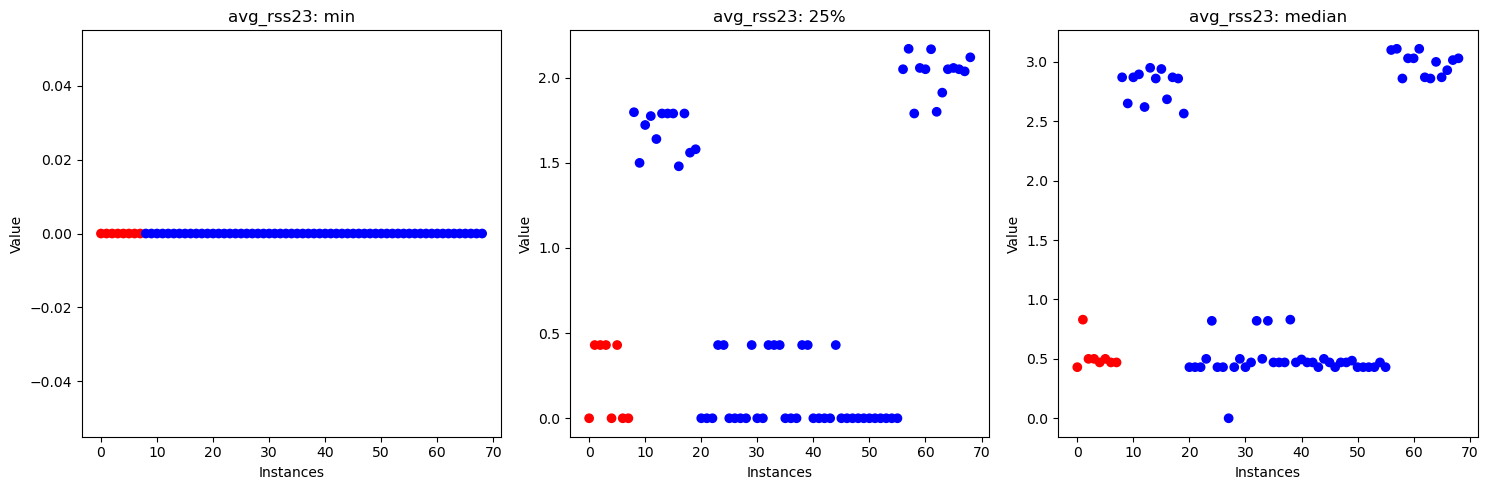

In [4]:
features = {
    'avg_rss12': [2, 3, 4],  # min, 25%, median for avg_rss12
    'var_rss12': [9, 10, 11],  # min, 25%, median for var_rss12
    'avg_rss23': [23, 24, 25]  # min, 25%, median for avg_rss23
}

# bending: red, other: blue
colors = ['r' if label == 0 
          else 'b' for label in train_label]

for feature, idxs in features.items():
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(range(len(train_feature)), train_feature[:, idxs[0]], color=colors)
    plt.title(f"{feature}: min")
    plt.xlabel('Instances')
    plt.ylabel('Value')

    plt.subplot(1, 3, 2)
    plt.scatter(range(len(train_feature)), train_feature[:, idxs[1]], color=colors)
    plt.title(f"{feature}: 25%")
    plt.xlabel('Instances')
    plt.ylabel('Value')

    plt.subplot(1, 3, 3)
    plt.scatter(range(len(train_feature)), train_feature[:, idxs[2]], color=colors)
    plt.title(f"{feature}: median")
    plt.xlabel('Instances')
    plt.ylabel('Value')

    plt.tight_layout()
    plt.show()

#### ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

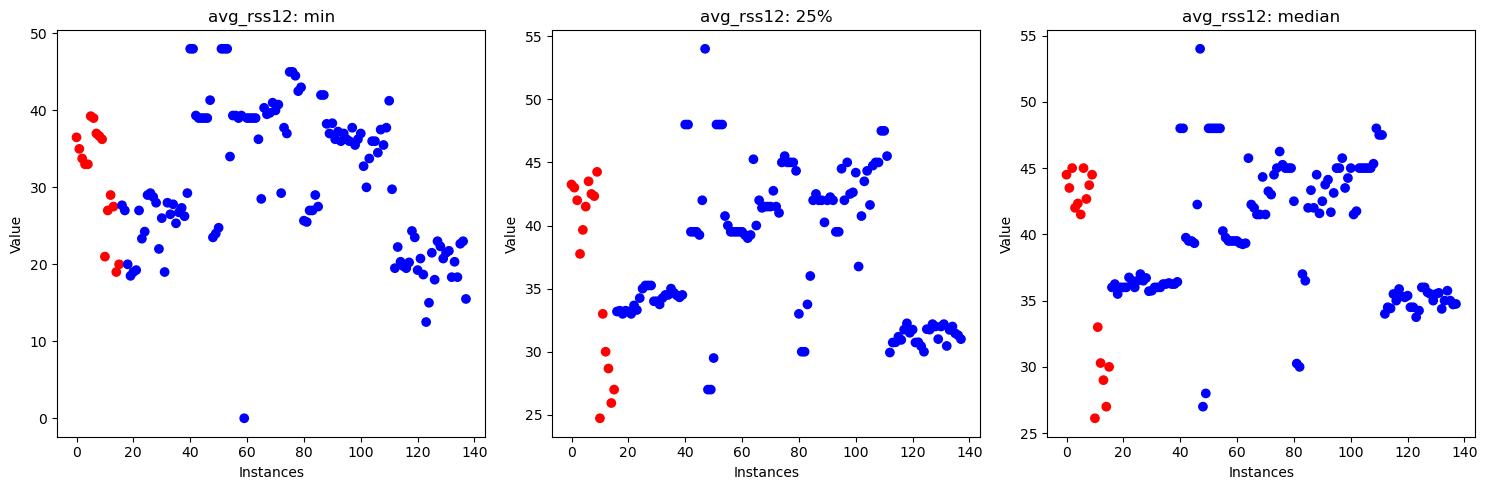

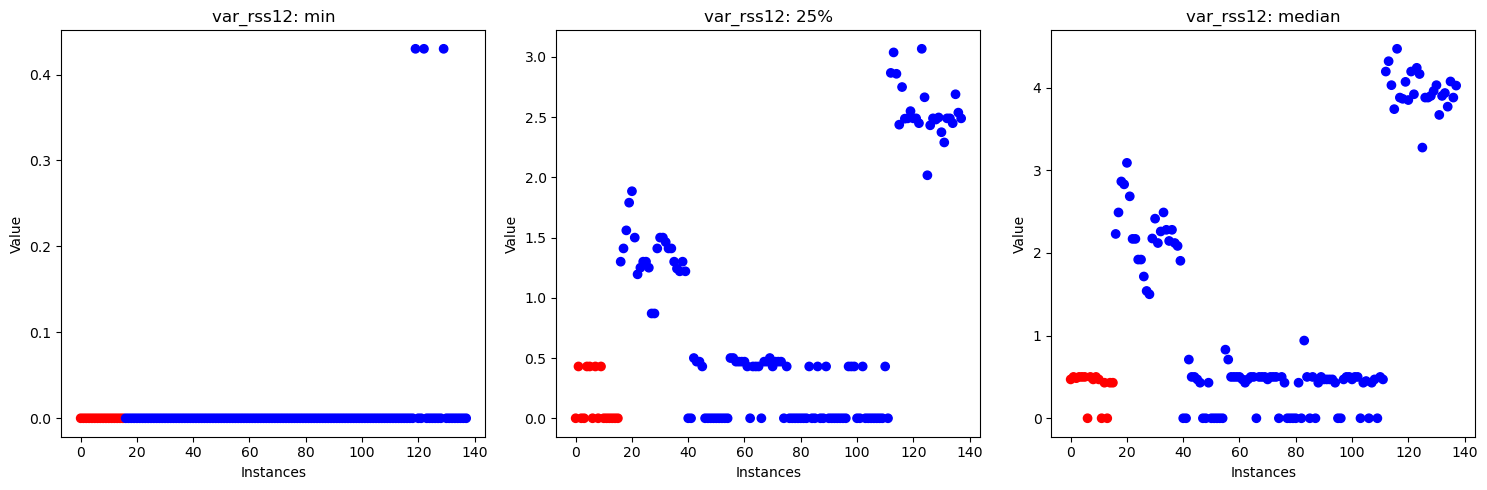

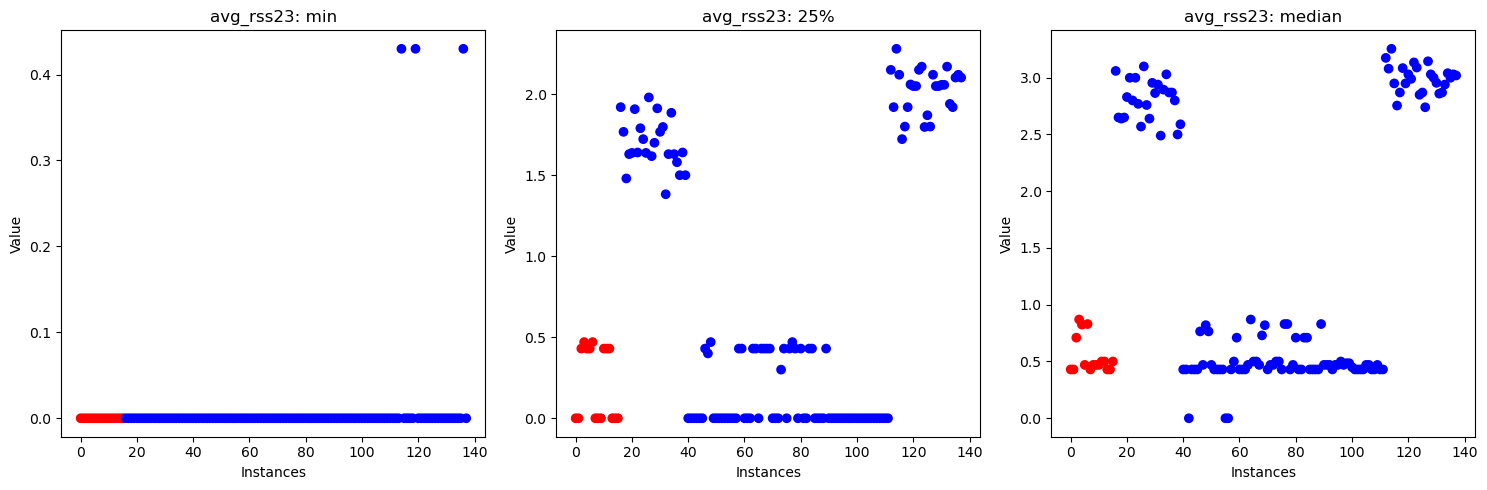

In [5]:
all_rows = []
for i, path in enumerate(folder_paths):
    csv_files = sorted(glob.glob(os.path.join(path, "*.csv")))
    
    for f in csv_files:
        df = pd.read_csv(f, names=column_names, skiprows=5)
        
        # split the dataframe
        middle = len(df) // 2
        df1 = df.iloc[:middle]
        df2 = df.iloc[middle:]
        
        for part_df in [df1, df2]:
            part_df = part_df.drop(columns="time").describe().drop('count')
            row_data = list(chain.from_iterable(part_df.transpose().values.tolist()))
            row_data.append(label_names[i])
            all_rows.append(row_data)

df_split = pd.DataFrame(all_rows, columns=columns)
df_split_list = df_split.values.tolist()
train_data_split = [row for idx, row in enumerate(df_split_list) if (idx // 2) not in testing_set_id]
train_data_split = np.array(train_data_split)
train_feature_split = train_data_split[:, :-1]
train_label_split = train_data_split[:, -1]

# plot 
colors_split = ['r' if label == 0 
                else 'b' for label in train_label_split]

for feature, idxs in features.items():
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(range(len(train_feature_split)), train_feature_split[:, idxs[0]], color=colors_split)
    plt.title(f"{feature}: min")
    plt.xlabel('Instances')
    plt.ylabel('Value')

    plt.subplot(1, 3, 2)
    plt.scatter(range(len(train_feature_split)), train_feature_split[:, idxs[1]], color=colors_split)
    plt.title(f"{feature}: 25%")
    plt.xlabel('Instances')
    plt.ylabel('Value')

    plt.subplot(1, 3, 3)
    plt.scatter(range(len(train_feature_split)), train_feature_split[:, idxs[2]], color=colors_split)
    plt.title(f"{feature}: median")
    plt.xlabel('Instances')
    plt.ylabel('Value')

    plt.tight_layout()
    plt.show()

No considerable difference in the results with those of 2(a)i, just having more data in the plots.

#### iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features.6 Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem.7 Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.

In [6]:
best_accuracy = 0
best_l = 0
best_p = 0

for l in range(1, 21):
    all_rows_l = []
    
    for i, path in enumerate(folder_paths):
        csv_files = sorted(glob.glob(os.path.join(path, "*.csv")))
        
        for f in csv_files:
            df = pd.read_csv(f,  names=column_names, skiprows=5)
            step = len(df) // l
            
            for k in range(l):
                df_part = df.iloc[k*step: (k+1)*step if k != l-1 else None]
                df_part = df_part.drop(columns="time").describe().drop('count')
                row_data = list(chain.from_iterable(df_part.transpose().values.tolist()))
                row_data.append(label_names[i])
                all_rows_l.append(row_data)

    df_l = pd.DataFrame(all_rows_l, columns=columns)
    train_data_l = np.array([row for idx, row in enumerate(df_l.values.tolist()) if (idx // (2*l)) not in testing_set_id])
    X = train_data_l[:, :-1]
    y = train_data_l[:, -1]
    
    # 5-fold cross validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        logistic = LogisticRegression(max_iter=5000, solver='liblinear')
        selector = RFE(logistic, n_features_to_select=5) 
        selector = selector.fit(X_train, y_train)
        selected_features = selector.support_
        logistic.fit(X_train[:, selected_features], y_train)
        predictions = logistic.predict(X_val[:, selected_features])
        accuracy = accuracy_score(y_val, predictions)
        accuracies.append(accuracy)
    
    mean_accuracy = np.mean(accuracies)
    
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_l = l
        best_p = 5

print(f"Best l: {best_l}")
print(f"Best p: {best_p}")
print(f"Accuracy: {best_accuracy}")

Best l: 6
Best p: 5
Accuracy: 0.6355092276144908


The right way to perform cross-validation in this problem is to first split the data into training and validation sets Then apply feature extraction and selection inside the cross-validation loop for each split. This let the feature selection is not biased by knowledge from the validation set.   

The wrong way is to extract and select features on the entire dataset first and then perform cross-validation. This leaks information from the validation set into the training process.

#### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.844     
Date:               2023-10-12 03:13 AIC:              17.7368   
No. Observations:   69               BIC:              28.9073   
Df Model:           4                Log-Likelihood:   -3.8684   
Df Residuals:       64               LL-Null:          -24.755   
Converged:          1.0000           LLR p-value:      1.8597e-08
No. Iterations:     11.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025     0.975]
-------------------------------------------------------------------
const    -0.0295     6.7229   -0.0044   0.9965   -13.2060   13.1471
x1        0.2299     0.5668    0.4057   0.6850    -0.8809    1.3408
x2       -0.2115     0.2001   -1.0570   0.2905    -0.6036    0.1806
x3       -8.0756     4.6

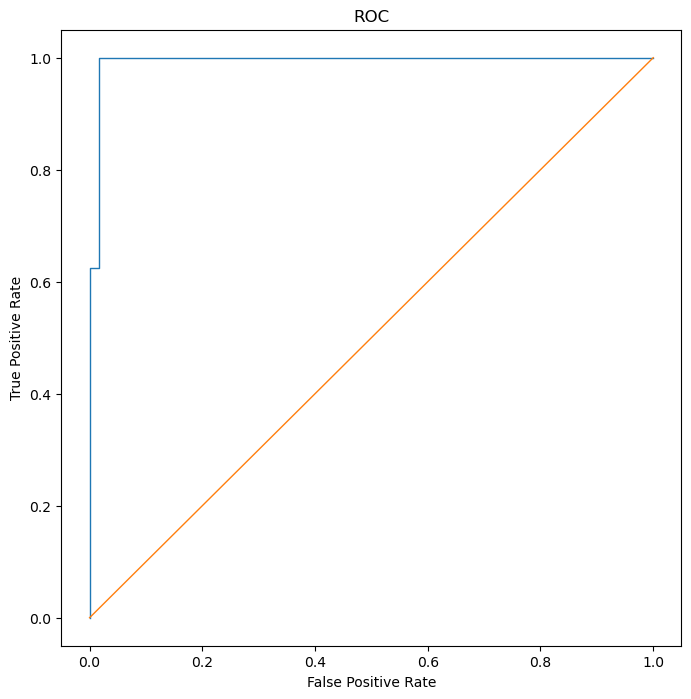

In [7]:
# 1 for bending, 0 for others
train_label_binary = np.where(train_label == 0, 1, 0)

mask = np.var(train_feature, axis=0) > 0.01
train_feature_reduced = train_feature[:, mask]

# calculate VIF
vifs = [variance_inflation_factor(train_feature_reduced, i) for i in range(train_feature_reduced.shape[1])]
while max(vifs) > 5:
    remove = vifs.index(max(vifs))
    train_feature_reduced = np.delete(train_feature_reduced, remove, axis=1)
    vifs = [variance_inflation_factor(train_feature_reduced, i) for i in range(train_feature_reduced.shape[1])]

# logistic regression
train_feature_constant = sm.add_constant(train_feature_reduced)
logit_model = sm.Logit(train_label_binary, train_feature_constant)
result = logit_model.fit(disp=0)
print(result.summary2())

# confusion matrix
predictions = result.predict(train_feature_constant)
binary_predictions = [1 if p > 0.5 else 0 for p in predictions]
conf_matrix = confusion_matrix(train_label_binary, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)

fpr, tpr, _ = roc_curve(train_label_binary, predictions)
roc_auc = auc(fpr, tpr)

# plot the curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, lw=1)
plt.plot([0, 1], [0, 1], lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

#### v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [8]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
l_best = 6

# to split a given instance into l segments
def extract_features(instance, l):
    # split the instance
    split_data = np.array_split(instance, l)
    features = []
    for segment in split_data:
        features.extend([np.mean(segment), np.std(segment), np.min(segment), np.percentile(segment, 25),
                         np.median(segment), np.percentile(segment, 75), np.max(segment)])
    return features

# feature extraction
test_feature_extracted = [extract_features(instance[:-1], l_best) for instance in test_data]

logistic = LogisticRegression(max_iter=5000)
rfe = RFE(logistic, n_features_to_select=3)
train_feature_extracted = [extract_features(instance[:-1], l_best) for instance in train_data]
clf_rfe = rfe.fit(np.array(train_feature_extracted), train_label)
test_predictions = clf_rfe.predict(test_feature_extracted)

# comopare the accuracy
test_accuracy = accuracy_score(test_label, test_predictions.round())
cross_val_accuracy = 0.6355092276144908
print(f"Accuracy on test set: {test_accuracy*100:.2f}%")
print(f"Cross-validation Accuracy: {cross_val_accuracy*100:.4}%")

Accuracy on test set: 78.95%
Cross-validation Accuracy: 63.55%


Accuracy on test set have a better result.

#### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

There is a significant difference between the test accuracy (78.95%) and the cross-validation accuracy (63.55%). That can means that data is well-seperated.

#### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model. 

Yes, it is imbalanced data, so we use case-control sampling.

Confusion Matrix:
[[ 0  8  0  0  0  0]
 [12  0  0  0  0  0]
 [ 8  4  0  0  0  0]
 [ 5  7  0  0  0  0]
 [10  2  0  0  0  0]
 [13  0  0  0  0  0]]


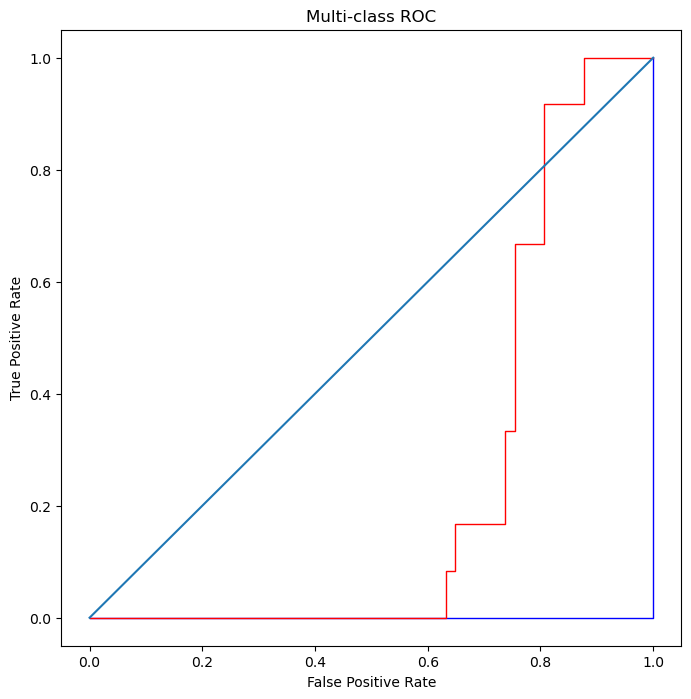

In [9]:
# case-control sampling
class_1 = train_feature[train_label == 0]
class_0 = train_feature[train_label == 1]
class_0_resampled = resample(class_0, replace=False, n_samples=len(class_1), random_state=42)
resampled_features = np.vstack((class_1, class_0_resampled))
resampled_labels = np.hstack((np.ones(len(class_1)), np.zeros(len(class_0_resampled))))

# logistic regression
logistic = LogisticRegression(max_iter=5000)
logistic.fit(resampled_features, resampled_labels)
predictions = logistic.predict(train_feature)
probabilities = logistic.predict_proba(train_feature)

# print confusion matrix
cm = confusion_matrix(train_label, predictions)
print("Confusion Matrix:")
print(cm)

y_bin = label_binarize(train_label, classes=[0, 1])
n_classes = y_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot the ROC curves
plt.figure(figsize=(8, 8))
colors = cycle(['blue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Repeat 2(a)iii using L1-penalized logistic regression,8 i.e. instead of using p- values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [10]:
best_l = 0
best_C = 0
best_accuracy = 0

def break_data(data, l):
    chunk_len = data.shape[1] // l
    chunks = []
    for i in range(l):
        start_idx = i * chunk_len
        if i == l - 1: 
            end_idx = data.shape[1]
        else:
            end_idx = start_idx + chunk_len
        chunks.append(data[:, start_idx:end_idx])
    return np.hstack(chunks)

l_values = list(range(1, 21))
C_values = np.logspace(-4, 4, 20)

for l in l_values:
    train_transformed = break_data(train_data, l)
    l1_logistic = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)
    grid = GridSearchCV(estimator=l1_logistic, param_grid={'C': C_values}, cv=5, scoring='accuracy')
    grid.fit(train_transformed, train_label)
    
    # best accuracy
    if grid.best_score_ > best_accuracy:
        best_l = l
        best_C = grid.best_params_['C']
        best_accuracy = grid.best_score_

print(f"Best l: {best_l}")
print(f"Best C: {best_C}")
print(f"Best Cross-validation Accuracy: {best_accuracy}")

Best l: 1
Best C: 0.23357214690901212
Best Cross-validation Accuracy: 0.9142857142857143


#### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

The accuracy in L1-penalized is higher. That means L1-penalized logistic regression performs better. It is easier to implement, too. Because it is directly built into many machine learning libraries, making it relatively easy to use. 

### (c) Multi-class Classification (The Realistic Case)

#### i. Find the best l in the same way as you found it in 2(b)i to build an L1- penalized multinomial regression model to classify all activities in your train- ing set.10 Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

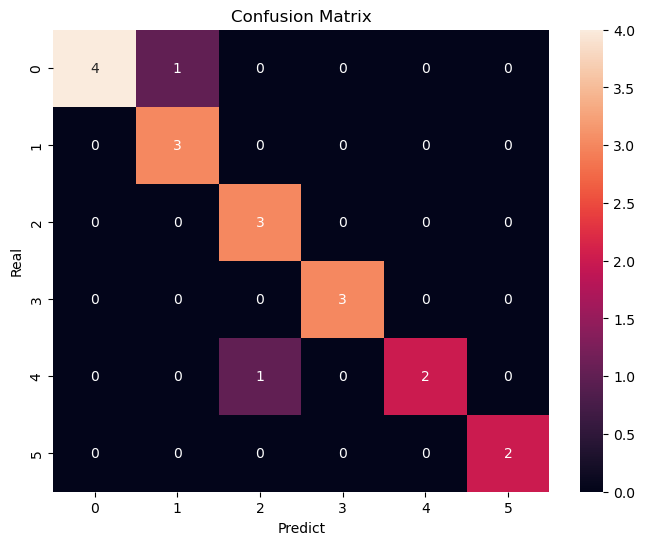

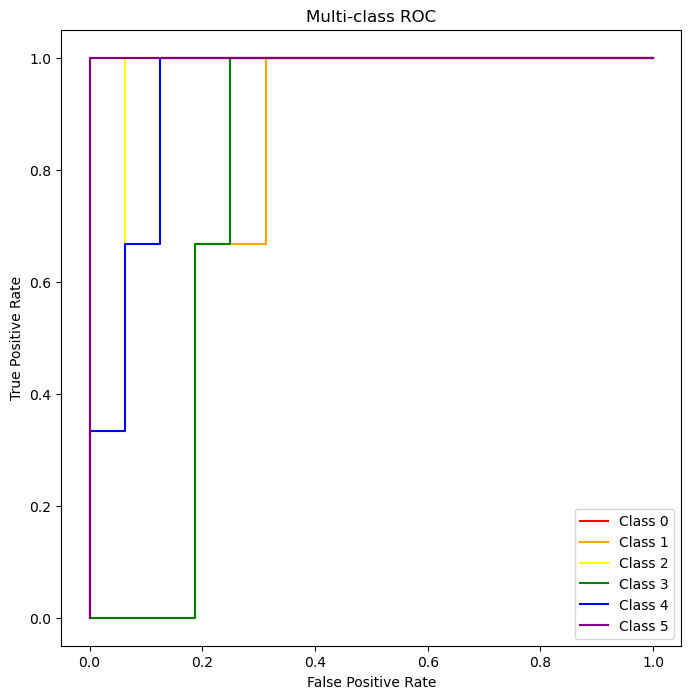

In [11]:
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'multi_class': ['multinomial'], 
    'solver': ['saga'], 
    'penalty': ['l1']
}
logistic = LogisticRegression(max_iter=10000)
grid = GridSearchCV(logistic, params, cv=5, scoring='accuracy')
grid.fit(train_feature, train_label)
best_multiclasss = grid.best_estimator_
predictions = best_multiclasss.predict(test_feature)
cm = confusion_matrix(test_label, predictions)

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

binarized_labels = label_binarize(test_label, classes=[0, 1, 2, 3, 4, 5])
predictions = best_multiclasss.decision_function(test_feature)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot the curves
plt.figure(figsize=(8, 8))
for i, color in zip(range(6), ['red', 'orange', 'yellow', 'green', 'blue', 'purple']):
    plt.plot(fpr[i], tpr[i], color=color, label=f'Class {i}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc='lower right')
plt.show()

#### ii. Repeat 2(c)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multi- nomial priors and compare the results.

In [12]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(train_feature, train_label)
gaussian_predictions = gaussian_nb.predict(test_feature)
gaussian_accuracy = accuracy_score(test_label, gaussian_predictions)

multinomial_nb = MultinomialNB()
multinomial_nb.fit(train_feature, train_label)
multinomial_predictions = multinomial_nb.predict(test_feature)
multinomial_accuracy = accuracy_score(test_label, multinomial_predictions)

print(f"Gaussian Naive Bayes Accuracy: {gaussian_accuracy * 100:.4f}%")
print(f"Multinomial Naive Bayes Accuracy: {multinomial_accuracy * 100:.4f}%")

Gaussian Naive Bayes Accuracy: 84.2105%
Multinomial Naive Bayes Accuracy: 84.2105%


They got the same result.

#### iii. Which method is better for multi-class classification in this problem?

For multi-class classification in this problem, consider test accuracy, model generalization, and data nature. Compare the performance of L1-penalized multinomial regression, GaussianNB, and MultinomialNB. The method with the highest consistent accuracy across training and testing is preferable, keeping in mind data distribution and interpretability. The "best" method varies based on these factors.

## ISLR, 4.8.3

After the calculation of terms in (4.12), the Bayes classifier is not linear since $x^2$ is in the final term.

## ISLR, 4.8.7

$$\begin{aligned}
P(Y=yes|X=4) &= \frac{\pi_{yes}f_{yes}(x)}{\sum_{l=1}^K \pi_lf_l(x)} = \frac{\pi_{yes}\exp(-1/2\sigma^2(x-\mu_{yes})^2)}{\sum_{l=1}^K\pi_l\exp(-1/2\sigma^2(x-\mu_l)^2)} = 0.75
\end{aligned}$$